# Use Case: Marketing Plan

Let's try to follow this procedure:
1. Frame the problem and look at the big picture.
1. Get the data.
1. Explore the data to gain insights.
1. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.
1. Explore many different models and short-list the best ones.
1. Fine-tune your models and combine them into a great solution.
1. Present your solution.
1. Launch, monitor, and maintain your system.

## Frame the problem and look at the big picture

Questions:
* How do we frame the problem?
* What is the big picture?

**Prepare our coding setup**

In [1]:
# code starts here
# some of the tools we use
from itertools import product

from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# These imports may not work out of the box when you run the code in Google Colab
# from util import XNAMES, YNAME, COLORS
# from util import plot_coefficients, generate_valid_budget_allocations, create_model_explorer, generate_budget_plans, predict_sales_and_compare_plans

# Therefore I include the code literally here.
# util.py
"""
Utilities to simplify live coding.
"""
from itertools import product

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


COLORS = {
    'TV': '#1b9e77',
    'radio': '#d95f02',
    'newspaper': '#7570b3',
}
XNAMES = ['TV', 'radio', 'newspaper']
YNAME = 'sales'


def plot_coefficients(coef, names):
    importance = pd.Series(coef, index=names, name='coef')
    fig, ax = plt.subplots()
    importance.plot.bar(ax=ax)
    ax.set_title('Coefficients')
    return fig


def create_model_explorer(df, model):

    def explore_budget_plan(tv_budget=140, radio_budget=20, newspaper_budget=30):
        planned_budget = pd.DataFrame([[tv_budget, radio_budget, newspaper_budget]], columns=XNAMES)
        
        sales_pred = model.predict(planned_budget)

        fig, axs = plt.subplots(figsize=(14, 6), ncols=3, sharey=True)
        for xname, ax in zip(XNAMES, axs):
            df.plot.scatter(ax=ax, x=xname, y=YNAME, color=COLORS[xname])

        for xname, ax in zip(XNAMES, axs):
            ax.scatter(planned_budget[xname][0], sales_pred, color='k', s=800, marker='+')
            # TODO add vlines and hlines
        return fig
        
    return explore_budget_plan  
 

def generate_valid_budget_allocations(total_budget):
    
    budget_options = range(0, total_budget + 1, 2)
    
    budget_allocations = []
    for budget_allocation in product(budget_options, budget_options, budget_options):
        if sum(budget_allocation) != total_budget:
            continue
        budget_allocations.append(budget_allocation)
    return pd.DataFrame(budget_allocations, columns=XNAMES)


def generate_budget_plans(reference, extra):
    budget_plans = reference[XNAMES].values + extra
    return budget_plans


def predict_sales_and_compare_plans(model, reference, budget_plans):
    sales_pred = model.predict(budget_plans)

    plan = budget_plans.copy()
    plan['predicted_sales'] = sales_pred
    
    absolute_difference = (plan - reference.values).sort_values('predicted_sales', ascending=False)

    relative_difference = ((plan - reference.values)/reference.values).sort_values('predicted_sales', ascending=False)

    return absolute_difference, relative_difference


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Get the data

Questions:
* How can we "get" the data?

In [2]:
# only works locally on a unix machine
# !head ./Advertising.csv

In [3]:
# read in the data
df = pd.read_csv('https://www.statlearning.com/s/Advertising.csv', index_col=0)
df

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9
...,...,...,...,...
196,38.2,3.7,13.8,7.6
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5


## Explore the data to gain insights

Questions:
* How can we explore the data?
* What kind of insights do we seek?

In [4]:
df.describe().round(0)

,TV,radio,newspaper,sales
count,200.0,200.0,200.0,200.0
mean,147.0,23.0,31.0,14.0
std,86.0,15.0,22.0,5.0
min,1.0,0.0,0.0,2.0
25%,74.0,10.0,13.0,10.0
50%,150.0,23.0,26.0,13.0
75%,219.0,37.0,45.0,17.0
max,296.0,50.0,114.0,27.0


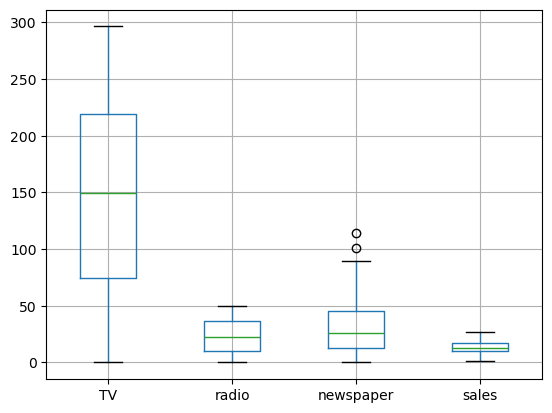

In [5]:
axs = df.boxplot()
axs.figure

In [6]:
df.corr().round(2)

,TV,radio,newspaper,sales
TV,1.00,0.05,0.06,0.78
radio,0.05,1.00,0.35,0.58
newspaper,0.06,0.35,1.00,0.23
sales,0.78,0.58,0.23,1.00


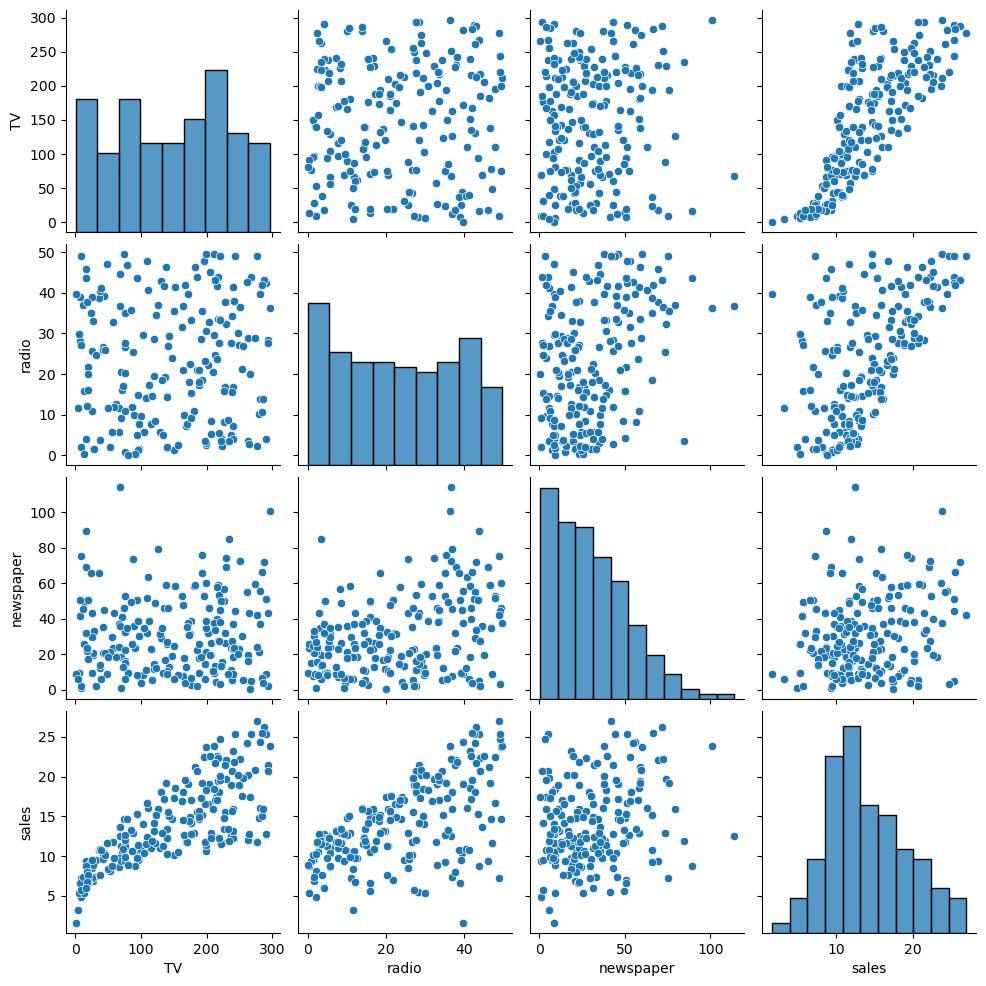

In [7]:
ag = sns.pairplot(data=df)
ag.figure

In [8]:
df.sort_values('TV', ascending=False).head()

,TV,radio,newspaper,sales
102,296.4,36.3,100.9,23.8
43,293.6,27.7,1.8,20.7
31,292.9,28.3,43.2,21.4
36,290.7,4.1,8.5,12.8
99,289.7,42.3,51.2,25.4


In [9]:
df.sort_values('radio', ascending=False).head()

,TV,radio,newspaper,sales
59,210.8,49.6,37.7,23.8
38,74.7,49.4,45.7,14.7
56,198.9,49.4,60.0,23.7
129,220.3,49.0,3.2,24.7
148,243.2,49.0,44.3,25.4


In [10]:
df.sort_values('newspaper', ascending=False).head()

,TV,radio,newspaper,sales
17,67.8,36.6,114.0,12.5
102,296.4,36.3,100.9,23.8
76,16.9,43.7,89.4,8.7
166,234.5,3.4,84.8,11.9
119,125.7,36.9,79.2,15.9


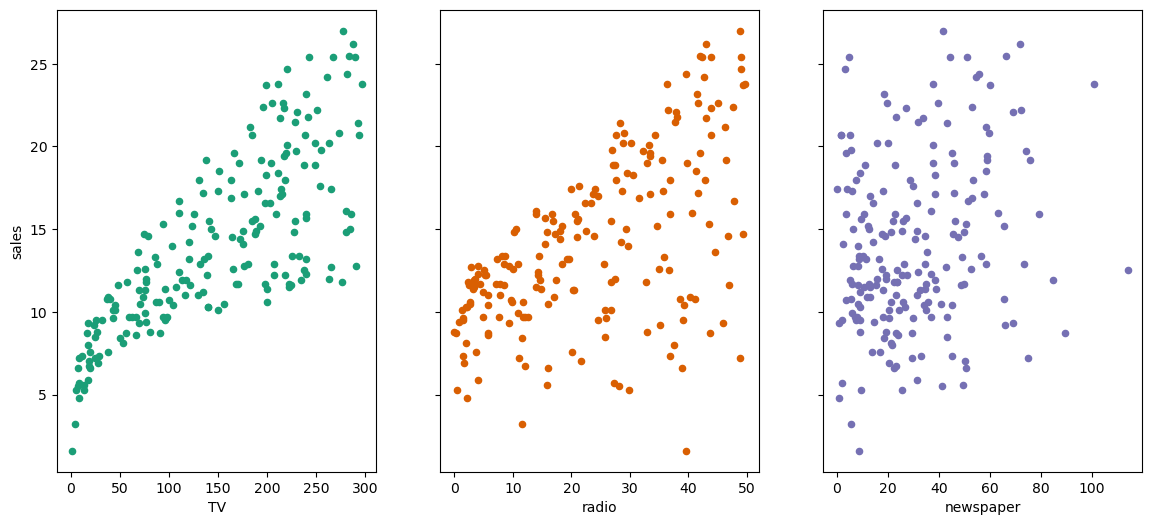

In [11]:
# let's zoom in a bit
fig, axs = plt.subplots(figsize=(14, 6), ncols=3, sharey=True)
for xname, ax in zip(XNAMES, axs):
    df.plot.scatter(ax=ax, x=xname, y=YNAME, color=COLORS[xname])

fig

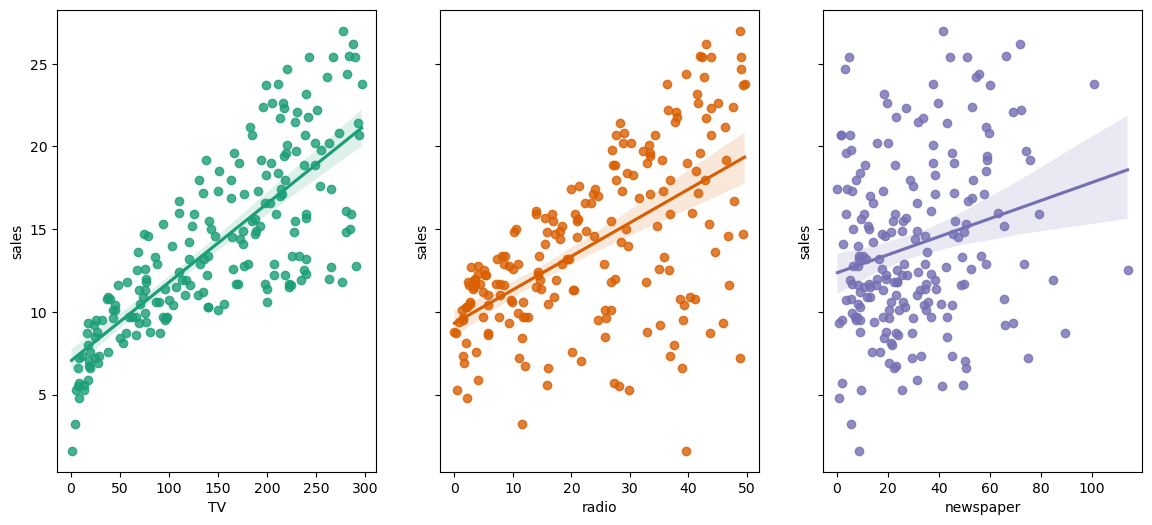

In [12]:
# and a bit more
fig, axs = plt.subplots(figsize=(14, 6), ncols=3, sharey=True)
for xname, ax in zip(XNAMES, axs):
    sns.regplot(data=df, x=xname, y=YNAME, ax=ax, color=COLORS[xname])

fig

### What have we learned?

Observations:
* ...

### How would you allocate resources?

Based on what we have learned so far...

## Prepare the data to better expose the underlying data patterns to Machine Learning algorithms

In this scenario, there is nothing to prepare right now.

Questions:
* What data preparation steps can you think of in **your** use case?

## Explore many different models and short-list the best ones

Let's take it step by step and explore **one** model.

Questions:
* What are we going to do now?
* Assuming we chose a linear model, explain the model equation.
* What kind of questions do we hope to answer once we have our model?

### Recall: Learning from Data

Let's follow this process:
1. Split data into train and test
2. Chose a model and:
  - fit
  - predict
  - evaluate (score, assess, ...)
3. Discuss
4. Iterate...

### Split Data

In [13]:
from sklearn.model_selection import train_test_split

X = df[XNAMES]
y = df[YNAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Select Model

In [14]:
from sklearn.linear_model import LinearRegression  # our first machine learning model

### Fit Model

In [15]:
model = LinearRegression()
model.fit(X_train, y_train)  # that's already it

LinearRegression()

### Predict

In [16]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_pred[:3]

array([16.38348211, 20.92434957, 21.61495426])

### Evaluate Scores/Metrics/*

In [17]:
from sklearn.metrics import r2_score
# https://en.wikipedia.org/wiki/Coefficient_of_determination
# the closer to 1 the better

r2_score(y_test, y_test_pred)

0.8935163320163658

In [18]:
# or even easier
model.score(X_test, y_test), model.score(X_train, y_train)

(0.8935163320163658, 0.8966445527601498)

**R2 (Coefficient of Determination)**

In the case of linear regression, R2 describes how well the variance in the data can be
described using a linear model.
The closer to 1, the better.

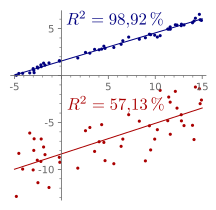

In [19]:
%%svg
https://upload.wikimedia.org/wikipedia/commons/4/4a/R2values.svg

**Visualize (Actual vs Prediction)**

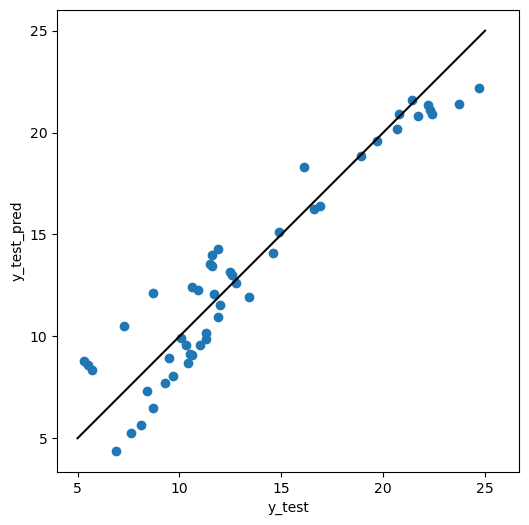

In [20]:
# or plot actual vs. prediction
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_test, y_test_pred)
ax.plot([5, 25], [5, 25], color='black')
ax.axis('square')
ax.set_xlabel('y_test')
ax.set_ylabel('y_test_pred')
fig

**Visualize (Residuals = Actual - Pred)**

In [21]:
df_test = X_test.assign(sales=y_test, sales_pred=y_test_pred)
df_test['actual-pred'] = df_test['sales'] - df_test['sales_pred']

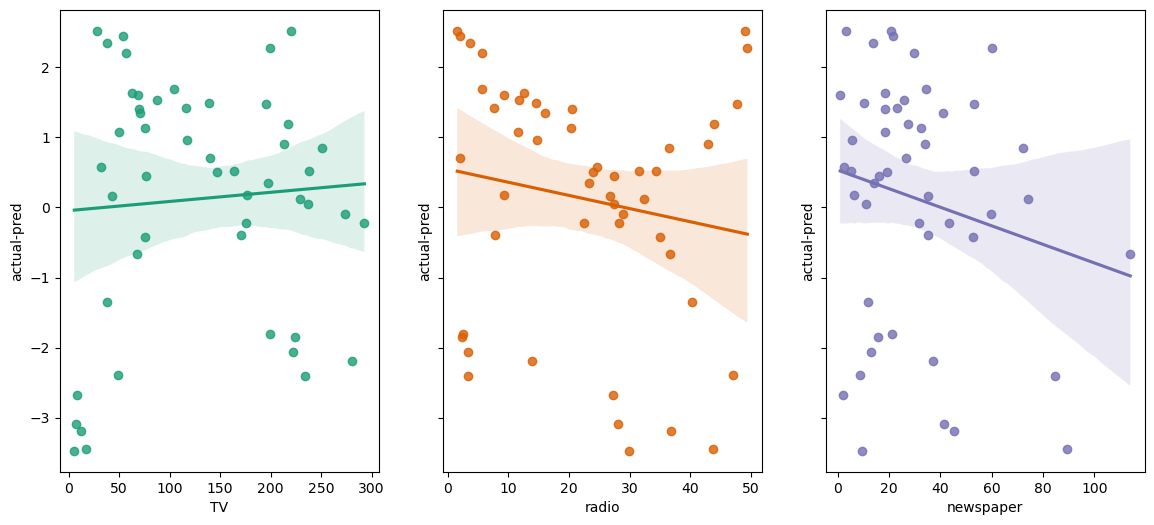

In [22]:
fig, axs = plt.subplots(figsize=(14, 6), ncols=3, sharey=True)

for xname, ax in zip(XNAMES, axs):
    sns.regplot(data=df_test, x=xname, y='actual-pred' , color=COLORS[xname], ax=ax)

fig

## Fine-tune your models and combine them into a great solution.

Let's take it step by step and see how our model from above can contribute to a solution.

Questions:
* What are we going to do now?

### Q&A: Investment in which channel is most valuable?

We can take a look at the model coefficients. The larger the absolute value of the coefficient, the more important the contributing factor.

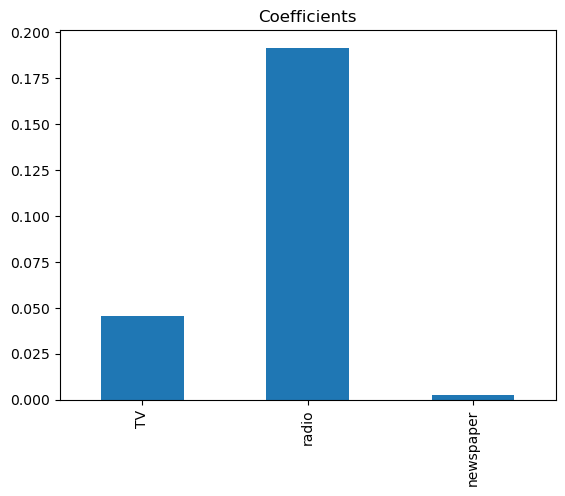

In [23]:
plot_coefficients(model.coef_, XNAMES)

In [24]:
explorer = interact(create_model_explorer(df_test, model), 
                    tv_budget=(0, 300), 
                    radio_budget=(0, 50),
                    newspaper_budget=(0, 100))
explorer

interactive(children=(IntSlider(value=140, description='tv_budget', max=300), IntSlider(value=20, description=…

<function __main__.create_model_explorer.<locals>.explore_budget_plan(tv_budget=140, radio_budget=20, newspaper_budget=30)>

### Q&A: How to optimally distribute additional resources?

Procedure:
1. Compute a range of different budget plans.
1. Make a prediction of each budget plan.
1. Assess the result.
1. Pick the plan with the largest increase in sales.

In [25]:
total_extra_budget = 20
extra_budget_allocations = generate_valid_budget_allocations(total_extra_budget)
extra_budget_allocations.sample(n=5)

,TV,radio,newspaper
44,8,12,0
46,10,2,8
61,16,2,2
47,10,4,6
23,4,4,12


**Status Quo**

In [26]:
status_quo = df.mean(axis=0).to_frame().T
status_quo  # this is where we are on average (budget-wise)

,TV,radio,newspaper,sales
0,147.0425,23.264,30.554,14.0225


**Possible Budget Plans**

In [27]:
possible_budget_plans = generate_budget_plans(status_quo, extra_budget_allocations)
possible_budget_plans

,TV,radio,newspaper
0,147.0425,23.264,50.554
1,147.0425,25.264,48.554
2,147.0425,27.264,46.554
3,147.0425,29.264,44.554
4,147.0425,31.264,42.554
...,...,...,...
61,163.0425,25.264,32.554
62,163.0425,27.264,30.554
63,165.0425,23.264,32.554
64,165.0425,25.264,30.554


**Assessment**

Compute impact of different budget plans on sales.

In [28]:
absolute_difference, relative_difference = predict_sales_and_compare_plans(model, status_quo, possible_budget_plans)
absolute_difference.head()

,TV,radio,newspaper,predicted_sales
10,0.0,20.0,0.0,3.798109
20,2.0,18.0,0.0,3.506063
9,0.0,18.0,2.0,3.420332
29,4.0,16.0,0.0,3.214017
19,2.0,16.0,2.0,3.128286


In [29]:
relative_difference.head().style.format('{:.0%}')

,TV,radio,newspaper,predicted_sales
10,0%,86%,0%,27%
20,1%,77%,0%,25%
9,0%,77%,7%,24%
29,3%,69%,0%,23%
19,1%,69%,7%,22%


**Decision**

Spend the entire additional budget on radio.

## Present your solution.

*Skipped.*

## Launch, monitor, and maintain your system.

*Skipped.*

Questions:
* What does "monitor" mean?
* What does "maintain" mean?

# Stepping Back

We learned something.

That's great!

Did we learn the *right* thing?

# Revision

Questions:
* What do you think?
* Do you have any critisism?